# Steps 
1. Read dataset
2. Scale the data
3. Create test and training sets
4. Define the LSTM and forward method
5. Train the model
6. Evaluate the model

In [29]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [30]:
df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/E92l5dmaQtjIeBdKEEtgUA/goldstock.csv')
df

,Unnamed: 0,Date,Close,Volume,Open,High,Low
0,0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2
1,1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
2,2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
3,3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
4,4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1
...,...,...,...,...,...,...,...
2506,2528,2014-01-28,1250.5,81426.0,1254.9,1261.9,1248.0
2507,2529,2014-01-27,1263.5,63419.0,1269.9,1280.1,1252.0
2508,2530,2014-01-24,1264.5,34998.0,1264.3,1273.2,1256.9
2509,2531,2014-01-23,1262.5,41697.0,1235.1,1267.1,1230.8


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2511 non-null   int64  
 1   Date        2511 non-null   object 
 2   Close       2511 non-null   float64
 3   Volume      2511 non-null   float64
 4   Open        2511 non-null   float64
 5   High        2511 non-null   float64
 6   Low         2511 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 137.4+ KB


In [32]:
df1 = df.sort_values(by="Date")
df1

,Unnamed: 0,Date,Close,Volume,Open,High,Low
2510,2532,2014-01-22,1238.6,80262.0,1240.5,1243.5,1235.5
2509,2531,2014-01-23,1262.5,41697.0,1235.1,1267.1,1230.8
2508,2530,2014-01-24,1264.5,34998.0,1264.3,1273.2,1256.9
2507,2529,2014-01-27,1263.5,63419.0,1269.9,1280.1,1252.0
2506,2528,2014-01-28,1250.5,81426.0,1254.9,1261.9,1248.0
...,...,...,...,...,...,...,...
4,4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1
3,3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
2,2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
1,1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7


In [33]:
df1 = df1[["Close", "Open", "High", "Low"]]
df1

,Close,Open,High,Low
2510,1238.6,1240.5,1243.5,1235.5
2509,1262.5,1235.1,1267.1,1230.8
2508,1264.5,1264.3,1273.2,1256.9
2507,1263.5,1269.9,1280.1,1252.0
2506,1250.5,1254.9,1261.9,1248.0
...,...,...,...,...
4,2051.6,2033.2,2067.3,2033.1
3,2030.2,2053.4,2062.8,2027.6
2,2006.5,2031.7,2036.1,2004.6
1,2021.6,2009.1,2025.6,2007.7


In [34]:
scaller = MinMaxScaler(feature_range=(-1,1))
gold_price = scaller.fit_transform(df1.values)
gold_price

array([[-0.63775755, -0.63754914, -0.65079672, -0.63058686],
       [-0.59195017, -0.64790488, -0.60521487, -0.63972017],
       [-0.58811691, -0.59190718, -0.59343312, -0.58900117],
       ...,
       [ 0.83402012,  0.87975837,  0.88005794,  0.86397202],
       [ 0.86296119,  0.83641768,  0.85977789,  0.86999611],
       [ 0.87771921,  0.87151213,  0.89126026,  0.89817334]])

In [35]:
tw = 7

def create_inout_seq(price, tw):
    inout_seq = []
    L = len(price)
    print("Length: ", L)

    for i in range(L-tw):
        data_seq = price[i:i+tw]
        data_label = price[i+tw:i+tw+1][0][3]
        inout_seq.append((data_seq, data_label))

    data = inout_seq
    print('Size of data: ', len(data))

    test_size = 20
    train_size = len(data) - (test_size)
    print("train size: ", train_size)
    print("test size: ", test_size)

    train = data[:train_size]
    test = data[train_size:]
    train = train[:-(tw-1)]
    return train, test


train, test = create_inout_seq(gold_price, tw)

Length:  2511
Size of data:  2504
train size:  2484
test size:  20


In [36]:
class LSTM(nn.Module):
    def __init__(self, input_size=4, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                       torch.zeros(1,1,self.hidden_layer_size),
                      )
        lstm_out, hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [37]:
model = LSTM()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from tqdm.notebook import tqdm 
epoch = 5
for i in tqdm(range(epoch)):
    epoch_loss=0
    for seq, labels in tqdm(train):
        seq = torch.from_numpy(np.array(seq)).type(torch.FloatTensor)
        labels = torch.from_numpy(np.array(labels)).type(torch.FloatTensor)

        optimizer.zero_grad()

        y_pred = model(seq)
        
        labels = labels.view(1)
        
        single_loss = loss_fn(y_pred, labels)
        single_loss.backward()
        optimizer.step()

        epoch_loss += single_loss.item()

    average_loss = epoch_loss / len(train)
    print(f'epoch: {i:3} loss: {average_loss:.10f}')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2478 [00:00<?, ?it/s]

epoch:   0 loss: 0.0038056965


  0%|          | 0/2478 [00:00<?, ?it/s]

epoch:   1 loss: 0.0021145848


  0%|          | 0/2478 [00:00<?, ?it/s]

epoch:   2 loss: 0.0014891527


  0%|          | 0/2478 [00:00<?, ?it/s]

epoch:   3 loss: 0.0012687078


  0%|          | 0/2478 [00:00<?, ?it/s]

epoch:   4 loss: 0.0010800382


In [38]:
model.eval()
actual, pred= [],[]

for seq,labels in test:
    seq = torch.from_numpy(np.array(seq)).type(torch.FloatTensor)
    labels = torch.from_numpy(np.array(labels)).type(torch.FloatTensor)
    actual.append(labels.item())
    with torch.no_grad():
        pred.append(model(seq).item())

actual = np.array(actual)
pred = np.array(pred)

In [39]:
actual = torch.from_numpy(np.array(actual)).type(torch.Tensor)
pred = torch.from_numpy(np.array(pred)).type(torch.Tensor)

In [40]:
actual_new = scaller.inverse_transform(np.c_[np.zeros(20), np.zeros(20),np.zeros(20), np.array(actual)])
actual_new

array([[1571.35      , 1572.95      , 1580.45      , 2040.59999954],
       [1571.35      , 1572.95      , 1580.45      , 2043.30001211],
       [1571.35      , 1572.95      , 1580.45      , 2058.20000086],
       [1571.35      , 1572.95      , 1580.45      , 2065.10000573],
       [1571.35      , 1572.95      , 1580.45      , 2072.80001206],
       [1571.35      , 1572.95      , 1580.45      , 2074.6       ],
       [1571.35      , 1572.95      , 1580.45      , 2067.60000261],
       [1571.35      , 1572.95      , 1580.45      , 2064.30000428],
       [1571.35      , 1572.95      , 1580.45      , 2038.29998769],
       [1571.35      , 1572.95      , 1580.45      , 2043.30001211],
       [1571.35      , 1572.95      , 1580.45      , 2030.79999706],
       [1571.35      , 1572.95      , 1580.45      , 2022.69999   ],
       [1571.35      , 1572.95      , 1580.45      , 2031.90000672],
       [1571.35      , 1572.95      , 1580.45      , 2025.89999582],
       [1571.35      , 1572.95    

In [41]:
pred_new = scaller.inverse_transform(np.c_[np.zeros(20), np.zeros(20),np.zeros(20), np.array(pred)])
pred_new

array([[1571.35      , 1572.95      , 1580.45      , 2050.67979702],
       [1571.35      , 1572.95      , 1580.45      , 2046.48416022],
       [1571.35      , 1572.95      , 1580.45      , 2047.73320781],
       [1571.35      , 1572.95      , 1580.45      , 2067.75710741],
       [1571.35      , 1572.95      , 1580.45      , 2063.05101804],
       [1571.35      , 1572.95      , 1580.45      , 2079.44282761],
       [1571.35      , 1572.95      , 1580.45      , 2071.53467735],
       [1571.35      , 1572.95      , 1580.45      , 2058.86544183],
       [1571.35      , 1572.95      , 1580.45      , 2062.65408456],
       [1571.35      , 1572.95      , 1580.45      , 2037.41167996],
       [1571.35      , 1572.95      , 1580.45      , 2044.19500645],
       [1571.35      , 1572.95      , 1580.45      , 2045.02411616],
       [1571.35      , 1572.95      , 1580.45      , 2031.9356789 ],
       [1571.35      , 1572.95      , 1580.45      , 2036.47530835],
       [1571.35      , 1572.95    

In [42]:
mae = mean_absolute_error(actual_new, pred_new)
mae

2.649007576256986

In [43]:
rmse = np.sqrt(mean_squared_error(actual_new, pred_new))
rmse

6.928452415294566

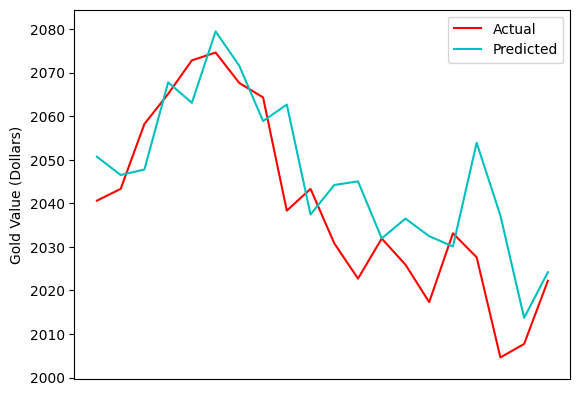

In [44]:
fig,ax = plt.subplots()

ax.plot(actual_new[:,3], 'r-', label="Actual")
ax.plot(pred_new[:,3], 'c-', label="Predicted")

ax.set_ylabel("Gold Value (Dollars)")

ax.set_ylim(min(min(actual_new[:,3]), min(pred_new[:,3]))-5, max(max(actual_new[:,3]),max(pred_new[:,3]))+5)
plt.xticks([])

ax.legend(loc = 'upper right')
plt.show()

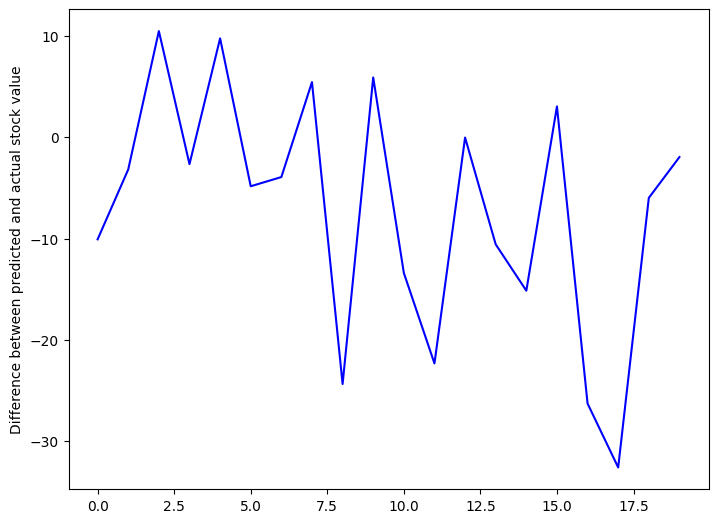

In [45]:
difference = actual_new - pred_new

fig = plt.figure()
diffGraph = fig.add_axes([0,0,1,1])
diffGraph.plot(difference[:,3], 'b')
diffGraph.set_ylabel('Difference between predicted and actual stock value')
plt.xticks()
plt.show()